In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
%matplotlib inline

yelp = pd.read_csv('yelp.csv')

/Users/muhammedeltabakh/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [3]:
yelp.shape


(10000, 10)

In [4]:
yelp.stars.value_counts().sort_index()

1     749
2     927
3    1461
4    3526
5    3337
Name: stars, dtype: int64

In [5]:
X = yelp.text
Y = yelp.stars

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42, test_size=0.15)

/Users/muhammedeltabakh/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# TFIDF 

I started with 34% accuracy no precision or recall for first 3 classes.

The model produced more than 17000 features 

In [8]:
my_words = ('pei', 'wei', 'pei wei', 'http www', 'oz', 'http www')

In [9]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS 
#vect = CountVectorizer(stop_words=ENGLISH_STOP_WORDS.union('just','place', '00','12'), lowercase=True, min_df=7)
TF = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union(my_words), lowercase=True, min_df=20, max_df=0.9,ngram_range=(1,3),max_features=2000)

After tuning the parametes, I used a Linear kernel for SVM. I ended up  with a 52 % model accuracy, better precision and recall than count vectorizer

In [10]:
x_train_dtm = TF.fit_transform(X_train)
x_train_dtm = x_train_dtm.todense()

In [11]:
x_test_dtm = TF.transform(X_test)
x_test_dtm = x_test_dtm.todense()

In [12]:
Y_train = csr_matrix(Y_train)
Y_train = Y_train.todense().reshape(8500,1)
Y_test = csr_matrix(Y_test)
Y_test = Y_test.todense().reshape(1500,1)


# PCA

I used pca for dimensionality reduction to reduce my features and I ended up with around 3600 features I took top 2000 in the tfidf vectorizer and I ended up with 54.5 % which is around 20 % increase in accuracy. 

Better precision and recall for class 2 and 3. The model is still having troubles finding class 2 and 3, but it  can predict them more precisely. 

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state=42)
nb = MultinomialNB()

fitting the data to PCA

In [15]:
pcad = pca.fit_transform(x_train_dtm)

In [16]:
x_test_dtm = pca.transform(x_test_dtm)

In [17]:
svm.fit(pcad, Y_train)

/Users/muhammedeltabakh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
y_pred_class = svm.predict(x_test_dtm)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(Y_test, y_pred_class)
print (accuracy)

0.545333333333


# Exploring the features 
I looked into the features tried to find some words that are affecting my model, added them to stop words 

In [20]:
print len(TF.get_feature_names())

2000


In [21]:
import numpy as np

vec = np.argsort(TF.idf_)[::-1]
features = TF.get_feature_names()

In [30]:
top_features = [features[i] for i in vec[:20]]

In [31]:
print top_features

[u'pasty', u'german', u'lee', u'yoga', u'frosting', u'library', u'lo', u'manicure', u'bus', u'select', u'fez', u'blah', u'doctor', u'trail', u'stadium', u'boba', u'bagel', u'safeway', u'pedicure', u'custard']


In [32]:
matrix_accuracy = confusion_matrix(Y_test, y_pred_class)
print matrix_accuracy

[[ 47  23  18  13   6]
 [ 16  40  21  34   9]
 [  8  17  72 103  29]
 [  4   9  35 352 161]
 [  8   2  11 155 307]]


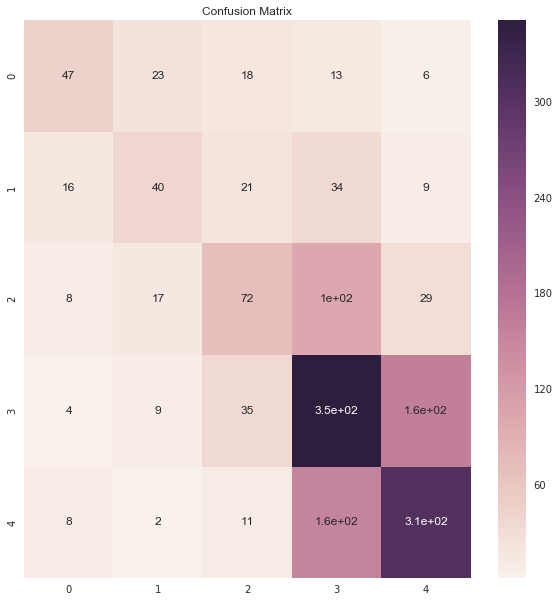

In [33]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix")

sns.heatmap(matrix_accuracy, annot=True)

In [34]:
from sklearn import metrics
print metrics.classification_report(Y_test, y_pred_class)

             precision    recall  f1-score   support

          1       0.57      0.44      0.49       107
          2       0.44      0.33      0.38       120
          3       0.46      0.31      0.37       229
          4       0.54      0.63      0.58       561
          5       0.60      0.64      0.62       483

avg / total       0.54      0.55      0.54      1500

